# rewrite `sector-count-using-func.py` using Notebook

In [1]:
import pandas as pd
import math as math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [28]:
# plot settings
%matplotlib inline

# seaborn setting
sns.set()

In [4]:
# read data
DF = pd.read_csv("input.csv", sep=',')

In [22]:
# analyze data
DF.head(5)

,planename,crosstime,counter%,time%,distance%,counter,time,distance,latitude,longitude,altitude,type,sectorname,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,FLT0232,18049,,,,,,,29.972764,125.165136,35975,B77W,begin,NaN,NaN,NaN
1,FLT0232,18049,,,,,,,29.972764,125.165136,35975,B77W,'F15',NaN,NaN,NaN
2,FLT0232,19013,,,,,,,28.348859,124.003006,35997,B77W,end,NaN,NaN,NaN
3,FLT0233,18068,,,,,,,21.142148,127.382083,31000,B739,begin,NaN,NaN,NaN
4,FLT0233,18068,,,,,,,21.142148,127.382083,31000,B739,'A05',NaN,NaN,NaN


In [23]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17135 entries, 0 to 17134
Data columns (total 16 columns):
planename      17135 non-null object
crosstime      17135 non-null int64
counter%       17135 non-null object
time%          17135 non-null object
distance%      17135 non-null object
counter        17135 non-null object
time           17135 non-null object
distance       17135 non-null object
latitude       17135 non-null float64
longitude      17135 non-null float64
altitude       17135 non-null int64
type           17135 non-null object
sectorname     16412 non-null object
Unnamed: 13    3696 non-null object
Unnamed: 14    263 non-null object
Unnamed: 15    1 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 2.1+ MB


In [25]:
# numerical fields only
DF.describe()

,crosstime,latitude,longitude,altitude
count,17135.000000,17135.000000,17135.000000,17135.000000
mean,31389.449198,34.424762,135.830470,21297.896644
std,10322.998520,3.761076,6.006943,14676.930653
min,0.000000,21.005936,123.915515,0.000000
25%,27666.000000,33.350536,131.633113,4635.000000
50%,34174.000000,34.627761,135.963509,26000.000000
75%,38992.500000,35.545162,139.822755,34983.500000
max,43199.000000,49.700000,165.000000,43001.000000


In [27]:
# Note: dont use df.field_name, instead using df['field_name'] is much better
# analyze values of sectorname
DF['sectorname'].unique()

array(['begin', "'F15'", 'end', "'A05'", "'N16'", "'N02-1'", "'N01-1'",
       nan, "'F07-1'", "'F05-1'", "'F05-3'", "'F07-2'", "'F08-1'",
       "'F17'", "'T17'", "'T09-1'", "'T10-1'", "'T09-3'", "'T14'",
       "'T04-1'", "'T12-1'", "'T13'", "'S03-1'", "'S01'", "'T01'",
       "'T02'", "'T03-1'", "'T07-1'", "'T04-3'", "'A04'", "'T11'",
       "'T24-1'", "'T23-1'", "'T26-1'", "'F03-1'", "'F03-2'", "'T06'",
       "'T27-1'", "'T26-2'", "'T22-1'", "'T21-1'", "'T23-2'", "'F11-2'",
       "'T12-3'", "'F16-1'", "'F02-4'", "'F01-1'", "'F02-1'", "'S02'",
       "'S04-1'", "'F06'", "'F01-2'", "'F16-3'", "'F16-2'", "'T28'",
       "'F02-3'", "'F02-2'", "'A03'", "'S03-2'", "'T27-2'", "'S31'",
       "'T07-2'", "'T22-2'", "'A01'", "'F03-3'", "'S34'", "'A02'",
       "'T09-2'", "'T26-4'", "'T26-3'", "'T04-2'", "'T21-2'", "'F11-1'",
       "'T15'"], dtype=object)

In [44]:
# functions
# this can be in a separated file for import & reuse in many notebooks

# filtered data and write it to a new DataFrame
def fil_df(df, sn):
    """
    Args:
        df (pandas.DataFrame)
        sn (str): name
    """
    idx = df[df.sectorname.str.contains(sn, na=False)].index.tolist()
    filtered_df = pd.DataFrame(columns=df.columns)
    for i in idx:
        # Note: each of this, get 3 rows?
        temp1 = df.iloc[[max(0, i - 1), i, min(df.index[-1], i + 1)]]
        
        # this is extremely bad!
        filtered_df = filtered_df.append(temp1, ignore_index=True)
    return filtered_df

# filtered data and write it to a new DataFrame
def fil_df_improved(df, sn):
    """I suppoes you want to filter sector with names contains sn, just do this

    Args:
        df (pandas.DataFrame)
        sn (str): name
    """
    return df[df.sectorname.str.contains(sn, na=False)]


# convert data
def transpose_df(df):
    """Note: to transpose df, just use df.T, like a matrix.
    """
    tdf = pd.DataFrame(columns=['plane_name',
                                'begin_time',
                                'leaving_time',
                                'previous_sector',
                                'current_sector',
                                'next_sector'])

    for row in range(1, len(df.index), 3):
        temp = pd.DataFrame([[df.at[row, 'planename'],
                              df.at[row, 'crosstime'],
                              df.at[min(row + 1, len(df.index) - 1), 'crosstime'],
                              df.at[row - 1, 'sectorname'],
                              df.at[row, 'sectorname'],
                              df.at[min(row + 1, len(df.index) - 1), 'sectorname']]], columns=tdf.columns)
        tdf = tdf.append(temp, ignore_index=True)
    return tdf


# function to calculate sector count
def sector_count(df, d, st):
    nst = int(d / st) + 1
    count = [0] * nst
    for line in df.index:
        if df.at[line, 'begin_time'] > d:
            pass
        elif df.at[line, 'begin_time'] == d:
            count[nst - 1] = count[nst - 1] + 1
        elif df.at[line, 'begin_time'] < d:
            if int(df.at[line, 'begin_time'] / st) == int(df.at[line, 'leaving_time'] / st):
                pass
            else:
                for i in range(math.ceil(df.at[line, 'begin_time'] / st),
                               min(nst, math.floor(df.at[line, 'leaving_time'] / st) + 1)):
                    count[i] = count[i] + 1
    return count


# output to csv file
def output_csv_no_index(df, sn):
    df.to_csv('result/result-' + sn + '.csv', index=False)


# plotting function
def plotting(count, sn):
    plt.plot(count)
    plt.xlabel('Time')
    plt.ylabel('Sector count [number of airplanes]')
    plt.title('Number of airplanes in Sector ' + sn)
    plt.axis([0, len(z), 0, max(z) + 1])
    plt.yticks(np.arange(0, max(z) + 1, 1))
    # additional plotting parameters
    plt.grid()
    # plt.xticks(np.arange(0, len(sector_count), 5))
    # plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right")
    plt.show()

In [45]:
# Note: do not use input, no production or data analysis code using input!
# using var, and can be changed later
name = 'end'

# get the observation period
duration = 1 * 3600 # 3 hours

# get the duration of one time step
step = 1 * 60 # minutes

In [33]:
%%time
x = fil_df(DF, name)

CPU times: user 4.25 s, sys: 45.9 ms, total: 4.3 s
Wall time: 4.3 s


In [34]:
# much better performance
%%time
x2 = fil_df_improved(DF, name)

CPU times: user 10.2 ms, sys: 722 µs, total: 10.9 ms
Wall time: 10.1 ms


In [47]:
# something wrong, Did I get wrong idea of the fil_df?
print(f"{len(x)} {len(x2)}")

4845 1615


In [46]:
# write data to the new DataFrame
x = fil_df(DF, name)
# print(x)

# convert data
y = transpose_df(x)  #  can be used x.T, if x is pandas.DataFrame


# sector count
z = sector_count(y, duration, step)

# output result
# output_csv_no_index(y, name)

<Figure size 1440x720 with 0 Axes>

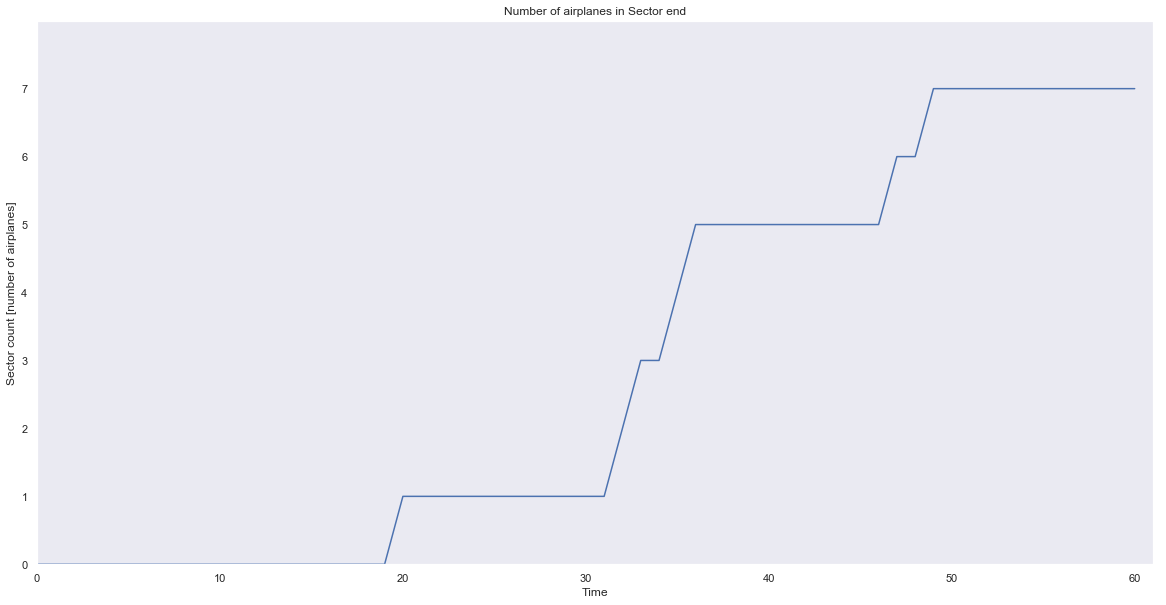

In [49]:
# plotting
fig = plt.figure(figsize=(20, 10))  # size, in inch if I remember correctly
plotting(z, name)